In [154]:
from scipy.fft import fft
from mutagen.wave import WAVE
from parselmouth.praat import call
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import librosa
import librosa.display
import parselmouth
import noisereduce as nr

In [6]:
def get_length(path, type):
    audio = WAVE(f'./wav_files/{type}/' + path)
    audio_info = audio.info
    return audio_info.length

train_df = pd.read_csv('./wav_files/train/train_data.csv')
train_df['Length'] = train_df['paths'].apply(lambda x: get_length(x, 'train'))

test_df = pd.read_csv('./wav_files/test/test_data.csv')
test_df['Length'] = test_df['paths'].apply(lambda x: get_length(x, 'test'))

validation_df = pd.read_csv('./wav_files/validation/validation_data.csv')
validation_df['Length'] = validation_df['paths'].apply(lambda x: get_length(x, 'validation'))

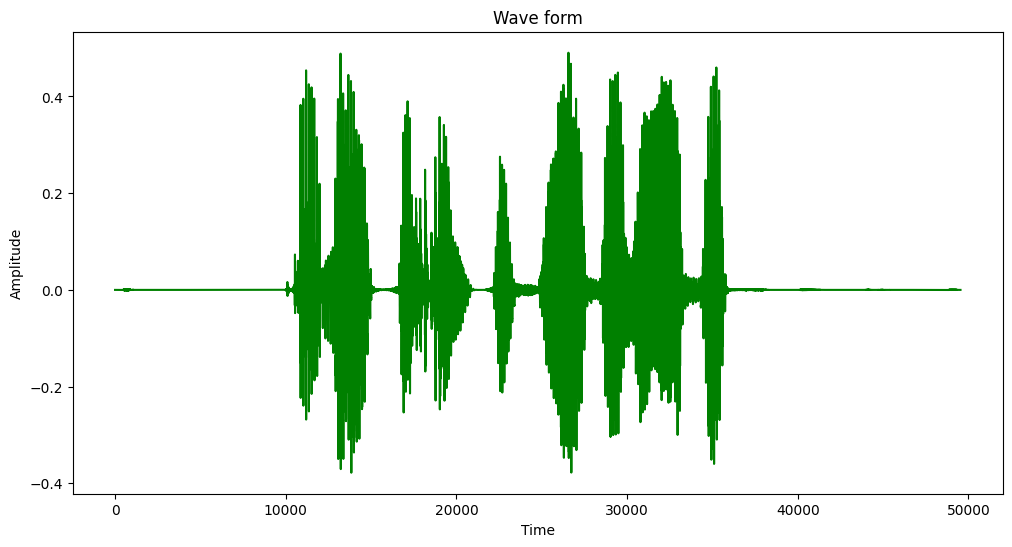

In [146]:
### Get the waveform of the audio file ###
path = './wav_files/train/' + train_df['paths'][0]

#sample_rate represent the number of samples per seconds in the original signal.
data, sample_rate = librosa.load(path, sr=None)

#clean data
data = nr.reduce_noise(y=data, sr=sample_rate)

plt.figure(figsize=(12,6))
plt.plot(data, color='green')
plt.title('Wave form')
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.show()

Text(0, 0.5, 'Power')

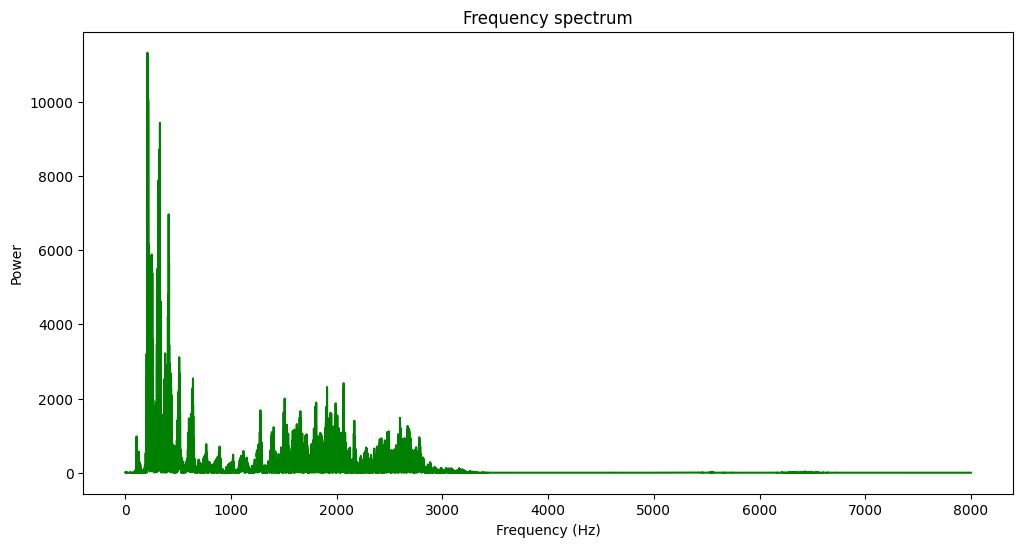

In [147]:
### Get the frequency spectrum ###

fourier_tranform = fft(data)

#Describe how the power = energy/sec varies with the frequency. 
#Better to use it instead of the magnitude spectrum here because it will be easier to find the MFCCs.
#Power = magnitude**2
#Contains the elements on the y axis.
power_spectrum = np.abs(fourier_tranform)**2 

#Find frequencies based on the power.
#Contains the elements on the x axis.
frequencies = np.linspace(0, sample_rate, len(power_spectrum))

plt.figure(figsize=(12, 6))

#Get the first half of the arrays because of the symetrie.
#Symetrie caused by the complex conjugate.
plt.plot(frequencies[:len(frequencies)//2], power_spectrum[:len(power_spectrum)//2], color='green')
plt.title('Frequency spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')

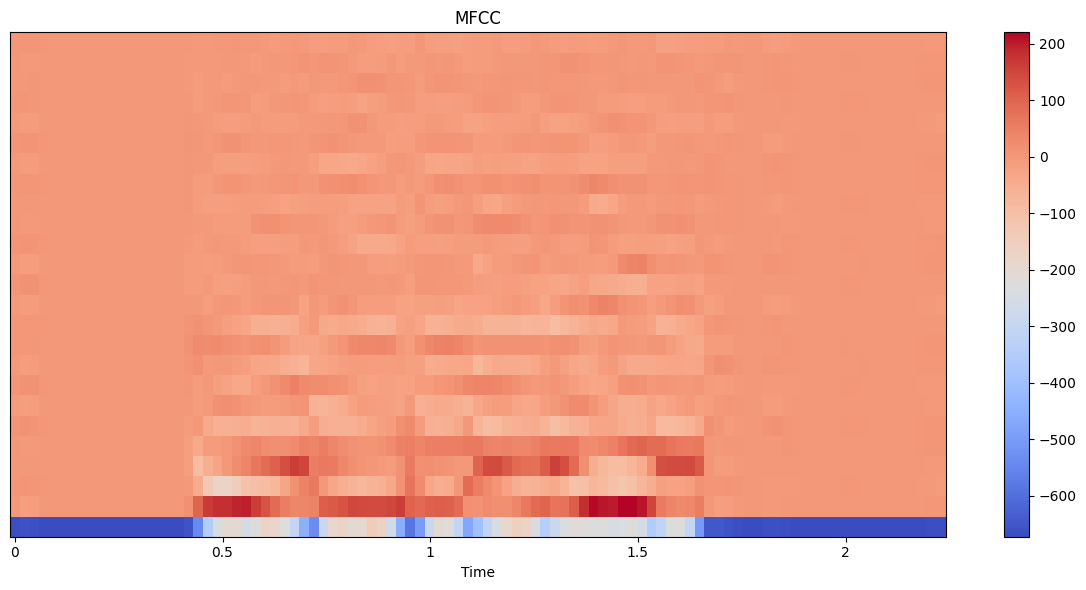

In [148]:
### Get MFCCs ###
mfccs = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=25)

mfccs_mean = np.mean(mfccs, axis=1)
mfccs_std = np.std(mfccs, axis=1)

# Normalization
mfccs_normalized = ((mfccs.T - mfccs_mean).T) / mfccs_std[:, np.newaxis]


plt.figure(figsize=(12,6))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

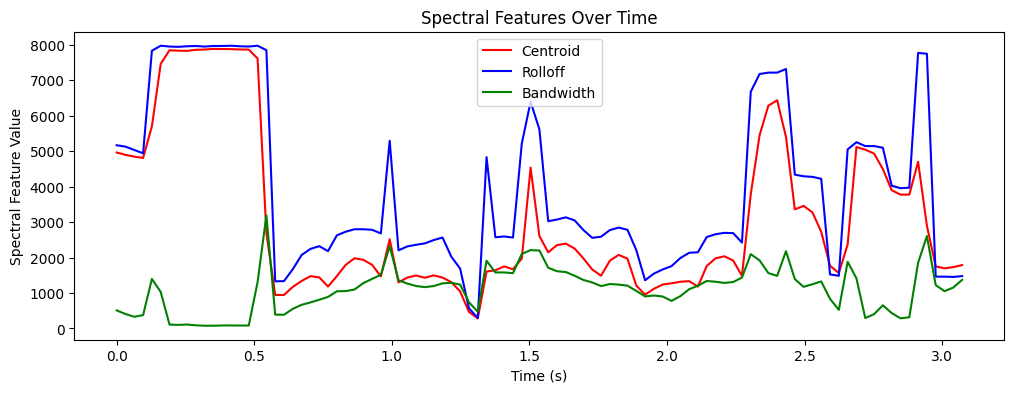

In [149]:
### Spectral measurements ###
spectral_centroids = librosa.feature.spectral_centroid(y=data, sr=sample_rate)[0]
spectral_rolloff = librosa.feature.spectral_rolloff(y=data, sr=sample_rate)[0]
spectral_bandwidth = librosa.feature.spectral_bandwidth(y=data, sr=sample_rate)[0]
#spectral_flatness = librosa.feature.spectral_flatness(y=data)[0]
#spectral_contrast = librosa.feature.spectral_contrast(y=data, sr=sample_rate)

t = librosa.frames_to_time(range(len(spectral_centroids)), sr=sample_rate)

# Plotting the Spectral Features
plt.figure(figsize=(12, 4))
plt.plot(t, spectral_centroids, color='red', label='Centroid')
plt.plot(t, spectral_rolloff, color='blue', label='Rolloff')
plt.plot(t, spectral_bandwidth, color='green', label='Bandwidth')

# For spectral flatness, there's no need to convert to dB since it's a ratio and typically small.
#plt.plot(t, spectral_flatness, color='orange', label='Flatness')

# For spectral contrast, it's common to average over the frequency bands since it returns an array of shape (n_bands, n_frames).
#spectral_contrast_avg = np.mean(spectral_contrast, axis=0)
#plt.plot(t, spectral_contrast_avg, color='black', label='Contrast')

plt.xlabel("Time (s)")
plt.ylabel("Spectral Feature Value")
plt.title("Spectral Features Over Time")
plt.legend(loc='best')
plt.show()

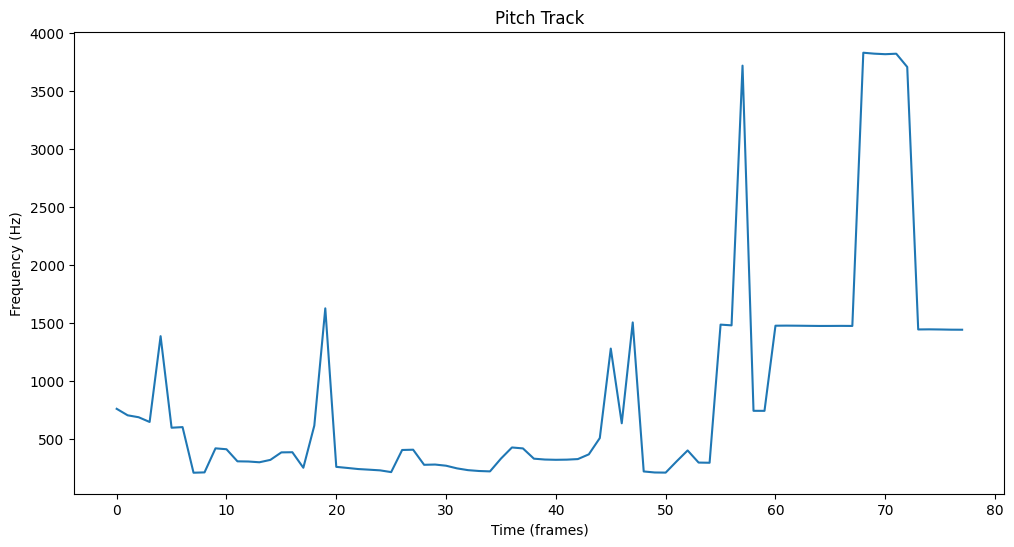

In [150]:
# Extract the pitch sequence
pitches, magnitudes = librosa.core.piptrack(y=data, sr=sample_rate)

# Select the dominant pitch at each frame
pitch_track = []
for t in range(pitches.shape[1]):
    index = magnitudes[:, t].argmax()
    pitch = pitches[index, t]
    pitch_track.append(pitch)

pitch_track = np.array(pitch_track)

# Remove zeros values (unvoiced frames)
pitch_track = pitch_track[pitch_track > 0]

plt.figure(figsize=(12, 6))
plt.plot(pitch_track)
plt.xlabel('Time (frames)')
plt.ylabel('Frequency (Hz)')
plt.title('Pitch Track')
plt.show()

In [151]:
### Get formants data ###

audio = parselmouth.Sound(path)
formants = audio.to_formant_burg()
number_points = int(audio.duration / 0.01) + 1
formant_data = {'time': [], 'F1': [], 'F2': [], 'F3': []}
for i in range(number_points):
    time = i * 0.01
    formant_data['time'].append(time)
    formant_data['F1'].append(formants.get_value_at_time(1, time))
    formant_data['F2'].append(formants.get_value_at_time(2, time))
    formant_data['F3'].append(formants.get_value_at_time(3, time))

formant_data


{'time': [0.0,
  0.01,
  0.02,
  0.03,
  0.04,
  0.05,
  0.06,
  0.07,
  0.08,
  0.09,
  0.1,
  0.11,
  0.12,
  0.13,
  0.14,
  0.15,
  0.16,
  0.17,
  0.18,
  0.19,
  0.2,
  0.21,
  0.22,
  0.23,
  0.24,
  0.25,
  0.26,
  0.27,
  0.28,
  0.29,
  0.3,
  0.31,
  0.32,
  0.33,
  0.34,
  0.35000000000000003,
  0.36,
  0.37,
  0.38,
  0.39,
  0.4,
  0.41000000000000003,
  0.42,
  0.43,
  0.44,
  0.45,
  0.46,
  0.47000000000000003,
  0.48,
  0.49,
  0.5,
  0.51,
  0.52,
  0.53,
  0.54,
  0.55,
  0.56,
  0.5700000000000001,
  0.58,
  0.59,
  0.6,
  0.61,
  0.62,
  0.63,
  0.64,
  0.65,
  0.66,
  0.67,
  0.68,
  0.6900000000000001,
  0.7000000000000001,
  0.71,
  0.72,
  0.73,
  0.74,
  0.75,
  0.76,
  0.77,
  0.78,
  0.79,
  0.8,
  0.81,
  0.8200000000000001,
  0.8300000000000001,
  0.84,
  0.85,
  0.86,
  0.87,
  0.88,
  0.89,
  0.9,
  0.91,
  0.92,
  0.93,
  0.9400000000000001,
  0.9500000000000001,
  0.96,
  0.97,
  0.98,
  0.99,
  1.0,
  1.01,
  1.02,
  1.03,
  1.04,
  1.05,
  1.06,
  1

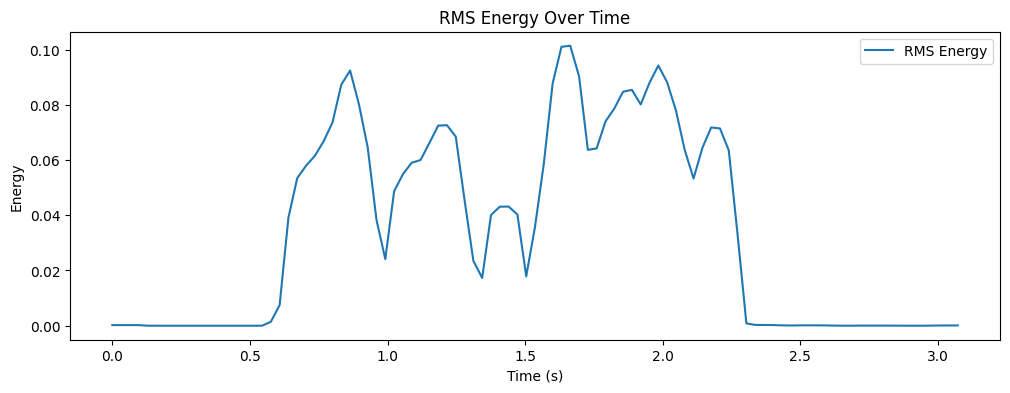

In [156]:
### Energy and Amplitude Features ###

# Root Mean Square (RMS) Energy - with a frame length of 2048 (default)
rms_energy = librosa.feature.rms(y=data, frame_length=2048, hop_length=512)

# Zero-Crossing Rate (ZCR) - with a frame length of 2048 (default)
zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=2048, hop_length=512)

# Plotting the results (e.g., RMS Energy over time)
frames = range(len(rms_energy[0]))
t = librosa.frames_to_time(frames, sr=sample_rate)

plt.figure(figsize=(12, 4))
plt.plot(t, rms_energy[0], label='RMS Energy')
plt.xlabel("Time (s)")
plt.ylabel("Energy")
plt.title("RMS Energy Over Time")
plt.legend()
plt.show()

In [190]:
### Voice Quality Features ###
# Load the cleaned sound into parselmouth.Sound
snd = parselmouth.Sound(data, sample_rate)

# Harmonics-to-Noise Ratio (HNR)
hnr = call(snd, "To Harmonicity (cc)", 0.01, 75, 0.1, 1.0)
hnr_mean = call(hnr, "Get mean", 0, 0)

print(hnr)

Object type: Harmonicity
Object name: untitled
Date: Sun Mar 10 01:10:43 2024

Time domain:
   Start time: 0 seconds
   End time: 3.096 seconds
   Total duration: 3.096 seconds
Time sampling:
   Number of frames: 307 (115 sounding)
   Time step: 0.01 seconds
   First frame centred at: 0.0179999999999999 seconds
Periodicity-to-noise ratios of sounding frames:
   Median 8.6615682 dB
   10 % = 1.26282238 dB   90 %% = 14.2439439 dB
   16 % = 3.60047893 dB   84 %% = 13.3542511 dB
   25 % = 5.48144934 dB   75 %% = 11.4739358 dB
Minimum: -1.63720613 dB
Maximum: 22.1950133 dB
Average: 8.64909844 dB
Standard deviation: 5.04373264 dB

